# Face Generation
In this project, you'll use generative adversarial networks to generate new images of faces.
### Get the Data
You'll be using two datasets in this project:
- MNIST
- CelebA

Since the celebA dataset is complex and you're doing GANs in a project for the first time, we want you to test your neural network on MNIST before CelebA.  Running the GANs on MNIST will allow you to see how well your model trains sooner.

If you're using [FloydHub](https://www.floydhub.com/), set `data_dir` to "/input" and use the [FloydHub data ID](http://docs.floydhub.com/home/using_datasets/) "R5KrjnANiKVhLWAkpXhNBe".

In [1]:
data_dir = './data'

# FloydHub - Use with data ID "R5KrjnANiKVhLWAkpXhNBe"
#data_dir = '/input'


"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import helper

helper.download_extract('mnist', data_dir)
helper.download_extract('celeba', data_dir)

Found mnist Data
Found celeba Data


## Explore the Data
### MNIST
As you're aware, the [MNIST](http://yann.lecun.com/exdb/mnist/) dataset contains images of handwritten digits. You can view the first number of examples by changing `show_n_images`. 

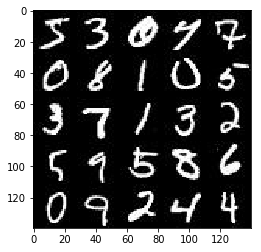

In [2]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
%matplotlib inline
import os
from glob import glob
from matplotlib import pyplot

mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'mnist/*.jpg'))[:show_n_images], 28, 28, 'L')
pyplot.imshow(helper.images_square_grid(mnist_images, 'L'), cmap='gray')

### CelebA
The [CelebFaces Attributes Dataset (CelebA)](http://mmlab.ie.cuhk.edu.hk/projects/CelebA.html) dataset contains over 200,000 celebrity images with annotations.  Since you're going to be generating faces, you won't need the annotations.  You can view the first number of examples by changing `show_n_images`.

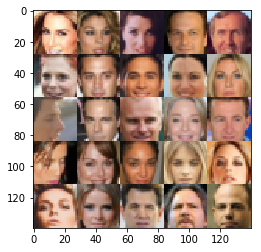

In [3]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'img_align_celeba/*.jpg'))[:show_n_images], 28, 28, 'RGB')
pyplot.imshow(helper.images_square_grid(mnist_images, 'RGB'))

## Preprocess the Data
Since the project's main focus is on building the GANs, we'll preprocess the data for you.  The values of the MNIST and CelebA dataset will be in the range of -0.5 to 0.5 of 28x28 dimensional images.  The CelebA images will be cropped to remove parts of the image that don't include a face, then resized down to 28x28.

The MNIST images are black and white images with a single [color channel](https://en.wikipedia.org/wiki/Channel_(digital_image%29) while the CelebA images have [3 color channels (RGB color channel)](https://en.wikipedia.org/wiki/Channel_(digital_image%29#RGB_Images).
## Build the Neural Network
You'll build the components necessary to build a GANs by implementing the following functions below:
- `model_inputs`
- `discriminator`
- `generator`
- `model_loss`
- `model_opt`
- `train`

### Check the Version of TensorFlow and Access to GPU
This will check to make sure you have the correct version of TensorFlow and access to a GPU

In [4]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
from distutils.version import LooseVersion
import warnings
import tensorflow as tf

# Check TensorFlow Version
assert LooseVersion(tf.__version__) >= LooseVersion('1.0'), 'Please use TensorFlow version 1.0 or newer.  You are using {}'.format(tf.__version__)
print('TensorFlow Version: {}'.format(tf.__version__))

# Check for a GPU
if not tf.test.gpu_device_name():
    warnings.warn('No GPU found. Please use a GPU to train your neural network.')
else:
    print('Default GPU Device: {}'.format(tf.test.gpu_device_name()))

TensorFlow Version: 1.1.0
Default GPU Device: /gpu:0


### Input
Implement the `model_inputs` function to create TF Placeholders for the Neural Network. It should create the following placeholders:
- Real input images placeholder with rank 4 using `image_width`, `image_height`, and `image_channels`.
- Z input placeholder with rank 2 using `z_dim`.
- Learning rate placeholder with rank 0.

Return the placeholders in the following the tuple (tensor of real input images, tensor of z data)

In [5]:
import problem_unittests as tests

def model_inputs(image_width, image_height, image_channels, z_dim):
    """
    Create the model inputs
    :param image_width: The input image width
    :param image_height: The input image height
    :param image_channels: The number of image channels
    :param z_dim: The dimension of Z
    :return: Tuple of (tensor of real input images, tensor of z data, learning rate)
    """
    real_input = tf.placeholder(tf.float32, (None, image_width, image_height, image_channels), name='real_input')
    z_input = tf.placeholder(tf.float32, (None, z_dim), name='z_input')
    learning_rate = tf.placeholder(tf.float32, name='learning_rate')
    return real_input, z_input, learning_rate


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_inputs(model_inputs)

Tests Passed


### Discriminator
Implement `discriminator` to create a discriminator neural network that discriminates on `images`.  This function should be able to reuse the variables in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "discriminator" to allow the variables to be reused.  The function should return a tuple of (tensor output of the discriminator, tensor logits of the discriminator).

In [6]:
import collections

Shape = collections.namedtuple('Shape', ('width', 'height', 'depth'))

# Shapes (just for information)
mnist_shape = Shape(28, 28, 1)
celeba_shape = Shape(28, 28, 3)

In [7]:
import functools
import operator

def flatten_size(shape):
    """Calculates flatten size by Shape"""
    return functools.reduce(operator.mul, shape)

def flatten(x, conv_shape):
    """Converts convolutional layer to dense layer"""
    return tf.reshape(x, (-1, flatten_size(conv_shape)))                    

def leaky_relu(x, alpha):
    return tf.maximum(alpha * x, x)

DISCRIMINATOR_VAR_SCOPE = 'discriminator'
                      
def discriminator(images, reuse=False, alpha=0.2, rate=0.2, kernel_size=3):
    """
    Create the discriminator network
    :param images: Tensor of input image(s)
    :param reuse: Boolean if the weights should be reused
    :return: Tuple of (tensor output of the discriminator, tensor logits of the discriminator)
    """
    
    kernel_initializer = tf.contrib.layers.xavier_initializer_conv2d
    
    with tf.variable_scope(DISCRIMINATOR_VAR_SCOPE, reuse=reuse):
        # Input layer is 28x28x1 or 28x28x3
        
        x1 = tf.layers.conv2d(images, 128, kernel_size, strides=2, padding='same', kernel_initializer=kernel_initializer())
        relu1 = leaky_relu(x1, alpha)
        # dropout1 = tf.layers.dropout(relu1, rate, training=True)
        out1 = relu1
        # 16x16x128 now
                
        x2 = tf.layers.conv2d(out1, 256, kernel_size, strides=2, padding='same', kernel_initializer=kernel_initializer())
        bn2 = tf.layers.batch_normalization(x2, training=True)
        relu2 = leaky_relu(bn2, alpha)
        # dropout2 = tf.layers.dropout(relu2, rate, training=True)
        out2 = relu2
        # 8x8x256 now
        
        x3 = tf.layers.conv2d(out2, 512, kernel_size, strides=2, padding='same', kernel_initializer=kernel_initializer())
        bn3 = tf.layers.batch_normalization(x3, training=True)
        relu3 = leaky_relu(bn3, alpha)
        # dropout3 = tf.layers.dropout(relu3, rate, training=True)
        out3 = relu3
        # 4x4x512 now

        out3_shape = Shape(*[int(dimension) for dimension in out3.shape[1:]])
        
        # Flatten it
        flat = flatten(out3, out3_shape)
        
        logits = tf.layers.dense(flat, 1, kernel_initializer=kernel_initializer())
        
        logits = tf.layers.dropout(logits, rate, training=True)
        
        out = tf.sigmoid(logits)
        
    return out, logits


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_discriminator(discriminator, tf)

Tests Passed


### Generator
Implement `generator` to generate an image using `z`. This function should be able to reuse the variables in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "generator" to allow the variables to be reused. The function should return the generated 28 x 28 x `out_channel_dim` images.

In [8]:
def start_convolutional(x, shape, kernel_initializer):
    """Starts convolutional stack
    
    shape is a Shape object
    """
    y = tf.layers.dense(x, flatten_size(shape), kernel_initializer=kernel_initializer)
    # Reshape y to start the convolutional stack
    y = tf.reshape(y, (-1, shape.width, shape.height, shape.depth))
    return y

GENERATOR_VAR_SCOPE = 'generator'

def generator(z, out_channel_dim, is_train=True, alpha=0.2, rate=0.2, kernel_size=3):
    """
    Create the generator network
    :param z: Input z
    :param out_channel_dim: The number of channels in the output image
    :param is_train: Boolean if generator is being used for training
    :return: The tensor output of the generator
    """
    
    kernel_initializer = tf.contrib.layers.xavier_initializer_conv2d
    
    with tf.variable_scope(GENERATOR_VAR_SCOPE, reuse=not is_train):
        
        x1 = start_convolutional(z, Shape(7, 7, 512), kernel_initializer())
        bn1 = tf.layers.batch_normalization(x1, training=is_train)
        relu1 = leaky_relu(bn1, alpha)
        # dropout1 = tf.layers.dropout(relu1, rate, training=is_train)
        out1 = relu1
        # 7x7x512 now
        
        x2 = tf.layers.conv2d_transpose(out1, 256, kernel_size, strides=1, padding='same',
                                        kernel_initializer=kernel_initializer())
        bn2 = tf.layers.batch_normalization(x2, training=is_train)
        relu2 = leaky_relu(bn2, alpha)
        # dropout2 = tf.layers.dropout(relu2, rate, training=is_train)
        out2 = relu2
        # 14x14x256 now
        
        x3 = tf.layers.conv2d_transpose(out2, 128, kernel_size, strides=2, padding='same',
                                        kernel_initializer=kernel_initializer())
        bn3 = tf.layers.batch_normalization(x3, training=is_train)
        relu3 = leaky_relu(bn3, alpha)
        # dropout3 = tf.layers.dropout(relu3, rate, training=is_train)
        out3 = relu3
        # 28x28x128 now
        
        # Output layer
        logits = tf.layers.conv2d_transpose(out3, out_channel_dim, 5, strides=2, padding='same',
                                            kernel_initializer=kernel_initializer())
        # 28x28x3 now (or 28x28x1)
        
        out = tf.tanh(logits)
        
        return out


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_generator(generator, tf)

Tests Passed


### Loss
Implement `model_loss` to build the GANs for training and calculate the loss.  The function should return a tuple of (discriminator loss, generator loss).  Use the following functions you implemented:
- `discriminator(images, reuse=False)`
- `generator(z, out_channel_dim, is_train=True)`

In [9]:
def model_loss(input_real, input_z, out_channel_dim, alpha=0.2,
               label_smoothness=0.1):
    """
    Get the loss for the discriminator and generator
    :param input_real: Images from the real dataset
    :param input_z: Z input
    :param out_channel_dim: The number of channels in the output image
    :return: A tuple of (discriminator loss, generator loss)
    """
    g_out = generator(input_z, out_channel_dim, is_train=True, alpha=alpha)
    d_real_out, d_real_logits = discriminator(input_real, reuse=False, alpha=alpha)
    d_fake_out, d_fake_logits = discriminator(g_out, reuse=True, alpha=alpha)
    
    d_loss_real = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(
            logits=d_real_logits, 
            labels=tf.ones_like(d_real_out) * (1 - label_smoothness)))
    
    d_loss_fake = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(
            logits=d_fake_logits, 
            labels=tf.zeros_like(d_fake_out)))
    
    d_loss = d_loss_real + d_loss_fake
    
    g_loss = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(
            logits=d_fake_logits, 
            labels=tf.ones_like(d_fake_out)))
    
    return d_loss, g_loss


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_loss(model_loss)

Tests Passed


### Optimization
Implement `model_opt` to create the optimization operations for the GANs. Use [`tf.trainable_variables`](https://www.tensorflow.org/api_docs/python/tf/trainable_variables) to get all the trainable variables.  Filter the variables with names that are in the discriminator and generator scope names.  The function should return a tuple of (discriminator training operation, generator training operation).

In [10]:
def model_opt(d_loss, g_loss, learning_rate, beta1):
    """
    Get optimization operations
    :param d_loss: Discriminator loss Tensor
    :param g_loss: Generator loss Tensor
    :param learning_rate: Learning Rate Placeholder
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :return: A tuple of (discriminator training operation, generator training operation)
    """
    t_vars = tf.trainable_variables()
    d_vars = [var for var in t_vars if var.name.startswith(DISCRIMINATOR_VAR_SCOPE)]
    g_vars = [var for var in t_vars if var.name.startswith(GENERATOR_VAR_SCOPE)]

    # Optimize
    with tf.control_dependencies(tf.get_collection(tf.GraphKeys.UPDATE_OPS)):
        d_train_opt = tf.train.AdamOptimizer(learning_rate, beta1=beta1).minimize(d_loss, var_list=d_vars)
        g_train_opt = tf.train.AdamOptimizer(learning_rate, beta1=beta1).minimize(g_loss, var_list=g_vars)

    return d_train_opt, g_train_opt


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_opt(model_opt, tf)

Tests Passed


## Neural Network Training
### Show Output
Use this function to show the current output of the generator during training. It will help you determine how well the GANs is training.

In [11]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import numpy as np

def show_generator_output(sess, n_images, input_z, out_channel_dim, image_mode):
    """
    Show example output for the generator
    :param sess: TensorFlow session
    :param n_images: Number of Images to display
    :param input_z: Input Z Tensor
    :param out_channel_dim: The number of channels in the output image
    :param image_mode: The mode to use for images ("RGB" or "L")
    """
    cmap = None if image_mode == 'RGB' else 'gray'
    z_dim = input_z.get_shape().as_list()[-1]
    example_z = np.random.uniform(-1, 1, size=[n_images, z_dim])

    samples = sess.run(
        generator(input_z, out_channel_dim, False),
        feed_dict={input_z: example_z})

    images_grid = helper.images_square_grid(samples, image_mode)
    pyplot.imshow(images_grid, cmap=cmap)
    pyplot.show()

### Train
Implement `train` to build and train the GANs.  Use the following functions you implemented:
- `model_inputs(image_width, image_height, image_channels, z_dim)`
- `model_loss(input_real, input_z, out_channel_dim)`
- `model_opt(d_loss, g_loss, learning_rate, beta1)`

Use the `show_generator_output` to show `generator` output while you train. Running `show_generator_output` for every batch will drastically increase training time and increase the size of the notebook.  It's recommended to print the `generator` output every 100 batches.

In [12]:
def train(epoch_count, batch_size, z_dim, learning_rate, beta1, get_batches, data_shape, data_image_mode, 
          alpha=0.2,
          print_every=10, show_every=50, show_images=25):
    """
    Train the GAN
    :param epoch_count: Number of epochs
    :param batch_size: Batch Size
    :param z_dim: Z dimension
    :param learning_rate: Learning Rate
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :param get_batches: Function to get batches
    :param data_shape: Shape of the data
    :param data_image_mode: The image mode to use for images ("RGB" or "L")
    """
    _, image_width, image_height, image_channels = data_shape      
    
    # Build model
    input_real, input_z, lr = model_inputs(image_width, image_height, image_channels, z_dim)        
    d_loss, g_loss = model_loss(input_real, input_z, data_shape[3], alpha=alpha)
    d_opt, g_opt = model_opt(d_loss, g_loss, lr, beta1)
    
    # let's go
    steps = 0
    
    with tf.Session() as sess:
        sess.run(tf.global_variables_initializer())
        
        for epoch_i in range(epoch_count):
            for batch_images in get_batches(batch_size):
                
                steps += 1
                
                # images normalization [-1, 1]
                batch_images = batch_images * 2
                
                # white noise for generator
                batch_z = np.random.uniform(-1, 1, size=(batch_size, z_dim))
                
                 # Run optimizers
                _ = sess.run(d_opt,
                             feed_dict={input_z: batch_z,
                                        input_real: batch_images,
                                        lr: learning_rate})
                _ = sess.run(g_opt, 
                             feed_dict={input_z: batch_z, 
                                        input_real: batch_images,
                                        lr: learning_rate})
                                
                if steps % print_every == 0:
                    # At the end of each epoch, get the losses and print them out
                    train_loss_d = d_loss.eval({input_z: batch_z, input_real: batch_images})
                    train_loss_g = g_loss.eval({input_z: batch_z})

                    print("Epoch {}/{}...".format(epoch_i+1, epoch_count),
                          "Discriminator Loss: {:.4f}...".format(train_loss_d),
                          "Generator Loss: {:.4f}".format(train_loss_g))

                if steps % show_every == 0:
                    #Print the current image
                    show_generator_output(sess, show_images, input_z, image_channels, data_image_mode)

### MNIST
Test your GANs architecture on MNIST.  After 2 epochs, the GANs should be able to generate images that look like handwritten digits.  Make sure the loss of the generator is lower than the loss of the discriminator or close to 0.

Epoch 1/2... Discriminator Loss: 1.1132... Generator Loss: 1.6137
Epoch 1/2... Discriminator Loss: 1.1690... Generator Loss: 4.8828
Epoch 1/2... Discriminator Loss: 0.8769... Generator Loss: 3.1823
Epoch 1/2... Discriminator Loss: 2.6030... Generator Loss: 0.4293
Epoch 1/2... Discriminator Loss: 1.0977... Generator Loss: 1.4859


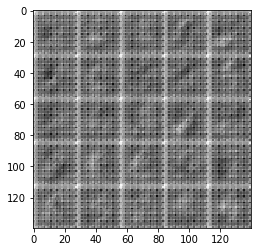

Epoch 1/2... Discriminator Loss: 1.1065... Generator Loss: 1.0271
Epoch 1/2... Discriminator Loss: 1.4620... Generator Loss: 0.5833
Epoch 1/2... Discriminator Loss: 1.8959... Generator Loss: 3.4626
Epoch 1/2... Discriminator Loss: 1.5263... Generator Loss: 0.4998
Epoch 1/2... Discriminator Loss: 1.1891... Generator Loss: 0.8081


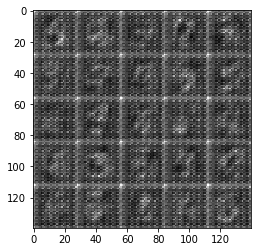

Epoch 1/2... Discriminator Loss: 1.1761... Generator Loss: 2.4298
Epoch 1/2... Discriminator Loss: 1.4006... Generator Loss: 0.5730
Epoch 1/2... Discriminator Loss: 0.9876... Generator Loss: 1.3768
Epoch 1/2... Discriminator Loss: 0.9653... Generator Loss: 1.5254
Epoch 1/2... Discriminator Loss: 2.0772... Generator Loss: 0.3485


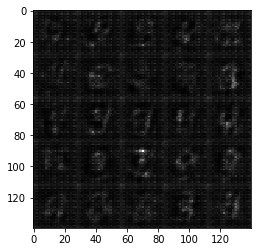

Epoch 1/2... Discriminator Loss: 1.1093... Generator Loss: 0.8927
Epoch 1/2... Discriminator Loss: 1.0155... Generator Loss: 1.3728
Epoch 1/2... Discriminator Loss: 0.9635... Generator Loss: 1.8748
Epoch 1/2... Discriminator Loss: 1.0794... Generator Loss: 0.8819
Epoch 1/2... Discriminator Loss: 0.8678... Generator Loss: 1.2960


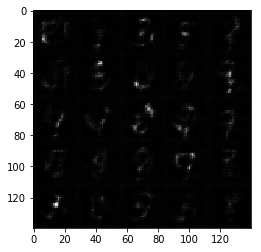

Epoch 1/2... Discriminator Loss: 0.9041... Generator Loss: 2.0210
Epoch 1/2... Discriminator Loss: 0.9352... Generator Loss: 1.4247
Epoch 1/2... Discriminator Loss: 1.1947... Generator Loss: 0.7093
Epoch 1/2... Discriminator Loss: 1.0674... Generator Loss: 1.0089
Epoch 1/2... Discriminator Loss: 0.8930... Generator Loss: 1.1947


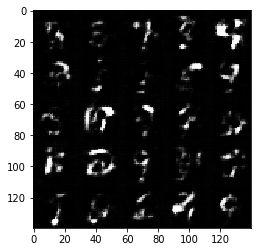

Epoch 1/2... Discriminator Loss: 0.8392... Generator Loss: 1.4216
Epoch 1/2... Discriminator Loss: 1.4409... Generator Loss: 0.6287
Epoch 1/2... Discriminator Loss: 1.3737... Generator Loss: 0.5856
Epoch 1/2... Discriminator Loss: 1.1622... Generator Loss: 0.7624
Epoch 1/2... Discriminator Loss: 0.9651... Generator Loss: 2.4587


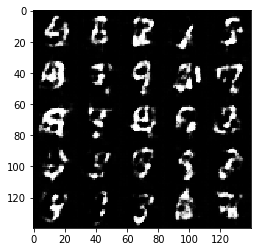

Epoch 1/2... Discriminator Loss: 0.9172... Generator Loss: 1.3188
Epoch 1/2... Discriminator Loss: 1.0370... Generator Loss: 1.0887
Epoch 1/2... Discriminator Loss: 0.9318... Generator Loss: 1.1455
Epoch 1/2... Discriminator Loss: 0.8594... Generator Loss: 1.3588
Epoch 1/2... Discriminator Loss: 1.1526... Generator Loss: 0.8106


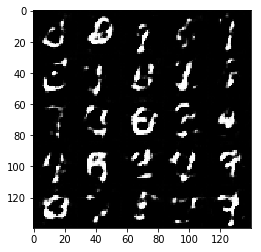

Epoch 1/2... Discriminator Loss: 0.9367... Generator Loss: 1.1772
Epoch 1/2... Discriminator Loss: 1.4493... Generator Loss: 0.5682
Epoch 1/2... Discriminator Loss: 1.5265... Generator Loss: 0.5629
Epoch 1/2... Discriminator Loss: 1.5285... Generator Loss: 0.5215
Epoch 1/2... Discriminator Loss: 1.4553... Generator Loss: 0.5629


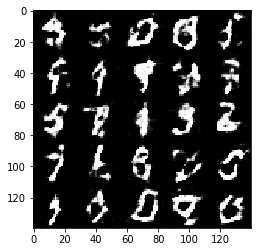

Epoch 1/2... Discriminator Loss: 0.9738... Generator Loss: 1.1683
Epoch 1/2... Discriminator Loss: 1.0114... Generator Loss: 1.1464
Epoch 1/2... Discriminator Loss: 0.9472... Generator Loss: 1.9060
Epoch 1/2... Discriminator Loss: 1.1165... Generator Loss: 0.7865
Epoch 1/2... Discriminator Loss: 0.8772... Generator Loss: 1.6080


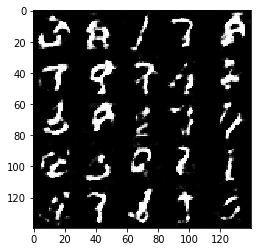

Epoch 1/2... Discriminator Loss: 0.9493... Generator Loss: 1.4949
Epoch 1/2... Discriminator Loss: 2.0330... Generator Loss: 0.3512
Epoch 1/2... Discriminator Loss: 0.9777... Generator Loss: 1.4860
Epoch 1/2... Discriminator Loss: 1.0359... Generator Loss: 0.9535
Epoch 1/2... Discriminator Loss: 0.9919... Generator Loss: 1.0388


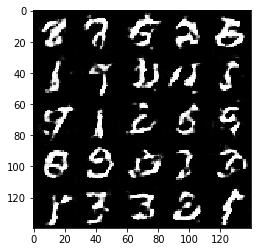

Epoch 1/2... Discriminator Loss: 0.9703... Generator Loss: 1.3598
Epoch 1/2... Discriminator Loss: 1.3322... Generator Loss: 0.6168
Epoch 1/2... Discriminator Loss: 1.0541... Generator Loss: 2.1003
Epoch 1/2... Discriminator Loss: 0.9885... Generator Loss: 1.0464
Epoch 1/2... Discriminator Loss: 1.0293... Generator Loss: 0.9551


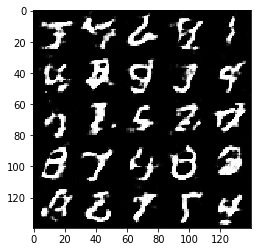

Epoch 1/2... Discriminator Loss: 1.1737... Generator Loss: 1.7285
Epoch 1/2... Discriminator Loss: 1.3019... Generator Loss: 0.6529
Epoch 1/2... Discriminator Loss: 1.1099... Generator Loss: 0.8435
Epoch 1/2... Discriminator Loss: 1.7408... Generator Loss: 0.4401
Epoch 1/2... Discriminator Loss: 0.9346... Generator Loss: 1.2622


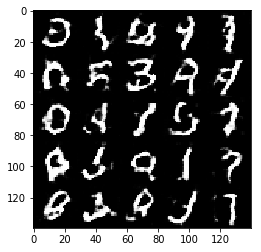

Epoch 1/2... Discriminator Loss: 1.1141... Generator Loss: 0.9215
Epoch 1/2... Discriminator Loss: 0.8559... Generator Loss: 1.5548
Epoch 1/2... Discriminator Loss: 1.0777... Generator Loss: 0.9733
Epoch 1/2... Discriminator Loss: 0.8784... Generator Loss: 1.1331
Epoch 1/2... Discriminator Loss: 1.7107... Generator Loss: 2.4976


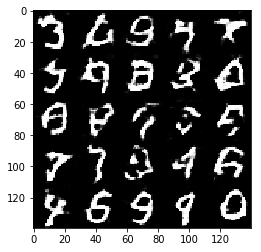

Epoch 1/2... Discriminator Loss: 1.7356... Generator Loss: 0.4782
Epoch 1/2... Discriminator Loss: 0.9881... Generator Loss: 1.6286
Epoch 1/2... Discriminator Loss: 1.1156... Generator Loss: 0.8787
Epoch 1/2... Discriminator Loss: 0.9001... Generator Loss: 1.3265
Epoch 1/2... Discriminator Loss: 1.0113... Generator Loss: 1.0418


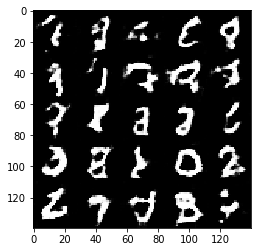

Epoch 1/2... Discriminator Loss: 1.4227... Generator Loss: 0.5796
Epoch 1/2... Discriminator Loss: 0.9738... Generator Loss: 1.2694
Epoch 1/2... Discriminator Loss: 0.8018... Generator Loss: 1.6871
Epoch 1/2... Discriminator Loss: 0.7949... Generator Loss: 1.5078
Epoch 1/2... Discriminator Loss: 3.6198... Generator Loss: 4.4924


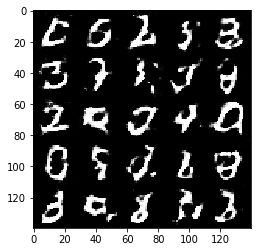

Epoch 1/2... Discriminator Loss: 1.0942... Generator Loss: 1.8032
Epoch 1/2... Discriminator Loss: 1.3651... Generator Loss: 0.6034
Epoch 1/2... Discriminator Loss: 1.6283... Generator Loss: 0.4282
Epoch 1/2... Discriminator Loss: 1.0748... Generator Loss: 0.9852
Epoch 1/2... Discriminator Loss: 0.8819... Generator Loss: 1.2561


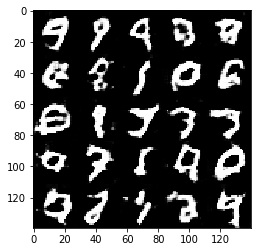

Epoch 1/2... Discriminator Loss: 0.8508... Generator Loss: 1.2656
Epoch 1/2... Discriminator Loss: 0.8885... Generator Loss: 1.1331
Epoch 1/2... Discriminator Loss: 0.8339... Generator Loss: 1.3062
Epoch 1/2... Discriminator Loss: 0.7450... Generator Loss: 1.8118
Epoch 1/2... Discriminator Loss: 0.8560... Generator Loss: 1.5206


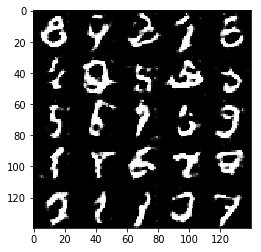

Epoch 1/2... Discriminator Loss: 1.6685... Generator Loss: 0.4392
Epoch 1/2... Discriminator Loss: 1.4189... Generator Loss: 2.4665
Epoch 1/2... Discriminator Loss: 0.9637... Generator Loss: 1.1273
Epoch 1/2... Discriminator Loss: 0.8895... Generator Loss: 1.1860
Epoch 1/2... Discriminator Loss: 0.8974... Generator Loss: 1.0790


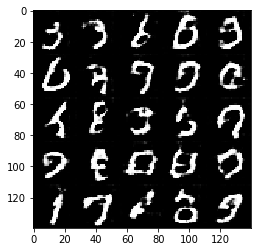

Epoch 1/2... Discriminator Loss: 1.2821... Generator Loss: 0.7532
Epoch 1/2... Discriminator Loss: 1.1962... Generator Loss: 0.8107
Epoch 1/2... Discriminator Loss: 0.9726... Generator Loss: 1.1248
Epoch 2/2... Discriminator Loss: 1.2563... Generator Loss: 0.7098
Epoch 2/2... Discriminator Loss: 0.7624... Generator Loss: 1.7948


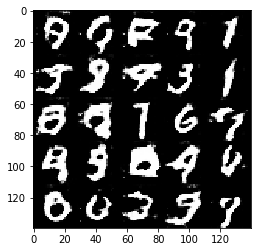

Epoch 2/2... Discriminator Loss: 0.8547... Generator Loss: 1.0698
Epoch 2/2... Discriminator Loss: 0.8799... Generator Loss: 1.9515
Epoch 2/2... Discriminator Loss: 0.8162... Generator Loss: 1.2766
Epoch 2/2... Discriminator Loss: 0.9338... Generator Loss: 1.0467
Epoch 2/2... Discriminator Loss: 1.0374... Generator Loss: 0.8838


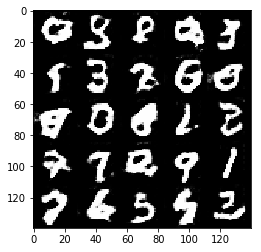

Epoch 2/2... Discriminator Loss: 1.0959... Generator Loss: 0.8234
Epoch 2/2... Discriminator Loss: 0.9420... Generator Loss: 1.5095
Epoch 2/2... Discriminator Loss: 1.1159... Generator Loss: 0.8181
Epoch 2/2... Discriminator Loss: 1.0078... Generator Loss: 0.8835
Epoch 2/2... Discriminator Loss: 1.0285... Generator Loss: 2.1244


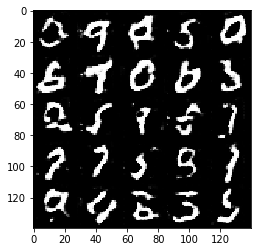

Epoch 2/2... Discriminator Loss: 0.8651... Generator Loss: 1.1517
Epoch 2/2... Discriminator Loss: 1.2854... Generator Loss: 0.7389
Epoch 2/2... Discriminator Loss: 0.9262... Generator Loss: 1.1823
Epoch 2/2... Discriminator Loss: 1.0519... Generator Loss: 0.8821
Epoch 2/2... Discriminator Loss: 0.9149... Generator Loss: 0.9487


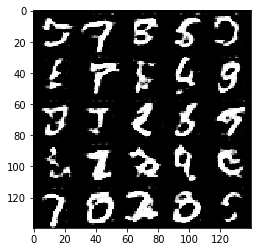

Epoch 2/2... Discriminator Loss: 1.5864... Generator Loss: 0.9619
Epoch 2/2... Discriminator Loss: 0.9676... Generator Loss: 1.0556
Epoch 2/2... Discriminator Loss: 1.0027... Generator Loss: 1.0070
Epoch 2/2... Discriminator Loss: 0.9652... Generator Loss: 1.1666
Epoch 2/2... Discriminator Loss: 1.0636... Generator Loss: 0.8697


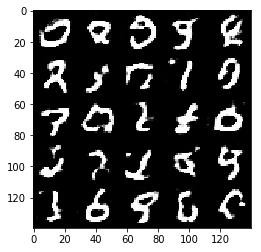

Epoch 2/2... Discriminator Loss: 0.8213... Generator Loss: 1.8884
Epoch 2/2... Discriminator Loss: 1.0558... Generator Loss: 0.9932
Epoch 2/2... Discriminator Loss: 1.0611... Generator Loss: 0.9518
Epoch 2/2... Discriminator Loss: 0.9938... Generator Loss: 0.9731
Epoch 2/2... Discriminator Loss: 0.9933... Generator Loss: 0.9563


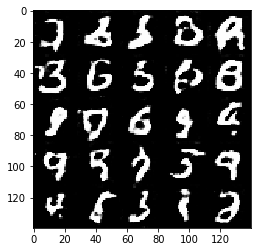

Epoch 2/2... Discriminator Loss: 1.6072... Generator Loss: 3.2301
Epoch 2/2... Discriminator Loss: 1.0268... Generator Loss: 1.4525
Epoch 2/2... Discriminator Loss: 0.9768... Generator Loss: 1.4542
Epoch 2/2... Discriminator Loss: 1.1878... Generator Loss: 0.8249
Epoch 2/2... Discriminator Loss: 0.8740... Generator Loss: 1.5162


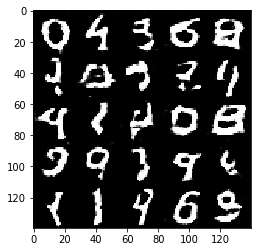

Epoch 2/2... Discriminator Loss: 0.9511... Generator Loss: 2.2694
Epoch 2/2... Discriminator Loss: 0.9787... Generator Loss: 0.9307
Epoch 2/2... Discriminator Loss: 1.2314... Generator Loss: 0.7904
Epoch 2/2... Discriminator Loss: 0.8450... Generator Loss: 1.5120
Epoch 2/2... Discriminator Loss: 0.8649... Generator Loss: 1.6866


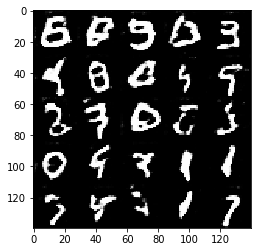

Epoch 2/2... Discriminator Loss: 0.8138... Generator Loss: 1.4436
Epoch 2/2... Discriminator Loss: 0.9310... Generator Loss: 1.2716
Epoch 2/2... Discriminator Loss: 0.8376... Generator Loss: 1.6389
Epoch 2/2... Discriminator Loss: 2.0147... Generator Loss: 4.1648
Epoch 2/2... Discriminator Loss: 1.1118... Generator Loss: 0.8451


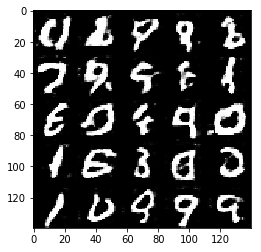

Epoch 2/2... Discriminator Loss: 1.0055... Generator Loss: 1.0128
Epoch 2/2... Discriminator Loss: 1.5179... Generator Loss: 3.1835
Epoch 2/2... Discriminator Loss: 0.9528... Generator Loss: 1.0233
Epoch 2/2... Discriminator Loss: 0.7934... Generator Loss: 1.4661
Epoch 2/2... Discriminator Loss: 0.8602... Generator Loss: 1.2809


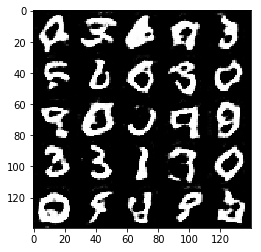

Epoch 2/2... Discriminator Loss: 1.3739... Generator Loss: 0.5912
Epoch 2/2... Discriminator Loss: 0.8535... Generator Loss: 1.2225
Epoch 2/2... Discriminator Loss: 1.1728... Generator Loss: 0.7654
Epoch 2/2... Discriminator Loss: 0.8125... Generator Loss: 1.6056
Epoch 2/2... Discriminator Loss: 0.8263... Generator Loss: 1.8198


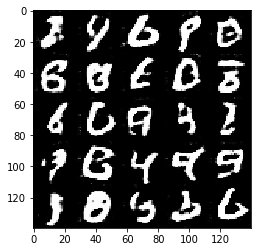

Epoch 2/2... Discriminator Loss: 1.0746... Generator Loss: 0.9269
Epoch 2/2... Discriminator Loss: 1.0931... Generator Loss: 0.9040
Epoch 2/2... Discriminator Loss: 1.1027... Generator Loss: 0.8761
Epoch 2/2... Discriminator Loss: 1.0117... Generator Loss: 1.0045
Epoch 2/2... Discriminator Loss: 0.9092... Generator Loss: 1.2834


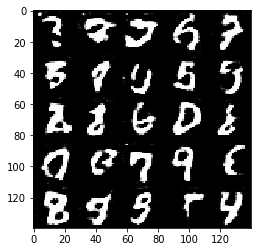

Epoch 2/2... Discriminator Loss: 0.7801... Generator Loss: 1.4333
Epoch 2/2... Discriminator Loss: 0.8894... Generator Loss: 1.2411
Epoch 2/2... Discriminator Loss: 0.7674... Generator Loss: 1.3742
Epoch 2/2... Discriminator Loss: 0.7523... Generator Loss: 1.6369
Epoch 2/2... Discriminator Loss: 0.9417... Generator Loss: 1.1576


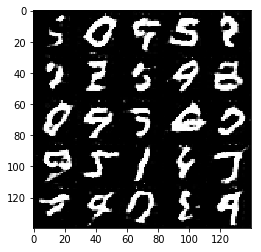

Epoch 2/2... Discriminator Loss: 0.9266... Generator Loss: 1.0474
Epoch 2/2... Discriminator Loss: 0.8906... Generator Loss: 1.8256
Epoch 2/2... Discriminator Loss: 0.9103... Generator Loss: 1.1674
Epoch 2/2... Discriminator Loss: 0.8265... Generator Loss: 1.7818
Epoch 2/2... Discriminator Loss: 0.8349... Generator Loss: 1.5157


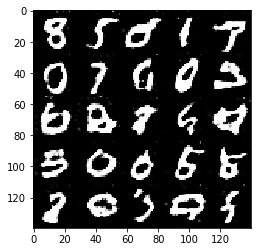

Epoch 2/2... Discriminator Loss: 1.0017... Generator Loss: 0.9616
Epoch 2/2... Discriminator Loss: 1.3800... Generator Loss: 1.8602
Epoch 2/2... Discriminator Loss: 1.2459... Generator Loss: 0.7033
Epoch 2/2... Discriminator Loss: 0.8234... Generator Loss: 1.4058
Epoch 2/2... Discriminator Loss: 0.7797... Generator Loss: 1.4451


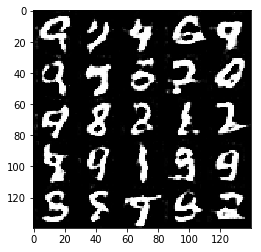

Epoch 2/2... Discriminator Loss: 0.8179... Generator Loss: 1.2410
Epoch 2/2... Discriminator Loss: 0.6863... Generator Loss: 1.8481
Epoch 2/2... Discriminator Loss: 0.7700... Generator Loss: 1.6831
Epoch 2/2... Discriminator Loss: 0.8463... Generator Loss: 1.3019
Epoch 2/2... Discriminator Loss: 0.9828... Generator Loss: 1.1016


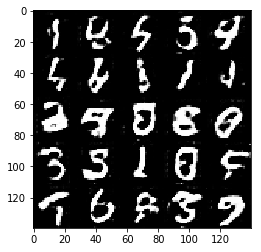

Epoch 2/2... Discriminator Loss: 0.8467... Generator Loss: 1.1395
Epoch 2/2... Discriminator Loss: 1.0658... Generator Loss: 0.8846
Epoch 2/2... Discriminator Loss: 1.3262... Generator Loss: 0.7006
Epoch 2/2... Discriminator Loss: 0.8263... Generator Loss: 1.5227
Epoch 2/2... Discriminator Loss: 0.8365... Generator Loss: 2.5940


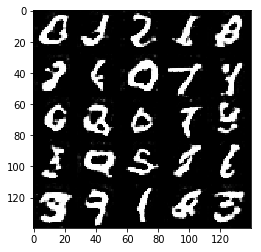

Epoch 2/2... Discriminator Loss: 0.9693... Generator Loss: 1.0846
Epoch 2/2... Discriminator Loss: 0.7389... Generator Loss: 1.5526
Epoch 2/2... Discriminator Loss: 1.0709... Generator Loss: 0.9770
Epoch 2/2... Discriminator Loss: 0.8204... Generator Loss: 1.4964
Epoch 2/2... Discriminator Loss: 1.1303... Generator Loss: 2.5263


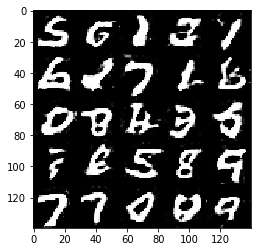

Epoch 2/2... Discriminator Loss: 0.9077... Generator Loss: 1.4223
Epoch 2/2... Discriminator Loss: 0.9415... Generator Loss: 0.9970
Epoch 2/2... Discriminator Loss: 1.0192... Generator Loss: 1.0393
Epoch 2/2... Discriminator Loss: 0.9519... Generator Loss: 1.1195
Epoch 2/2... Discriminator Loss: 0.8059... Generator Loss: 1.8992


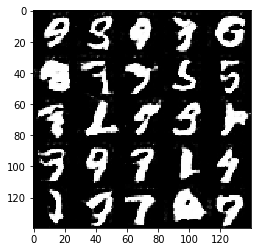

Epoch 2/2... Discriminator Loss: 0.8820... Generator Loss: 1.2350
Epoch 2/2... Discriminator Loss: 0.8433... Generator Loss: 1.2518


In [13]:
batch_size = 64
z_dim = 100
learning_rate = 0.0002
alpha = 0.05
beta1 = 0.3


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 2

mnist_dataset = helper.Dataset('mnist', glob(os.path.join(data_dir, 'mnist/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, mnist_dataset.get_batches,
          mnist_dataset.shape, mnist_dataset.image_mode, alpha=alpha)

### CelebA
Run your GANs on CelebA.  It will take around 20 minutes on the average GPU to run one epoch.  You can run the whole epoch or stop when it starts to generate realistic faces.

Epoch 1/1... Discriminator Loss: 1.5831... Generator Loss: 1.3172
Epoch 1/1... Discriminator Loss: 2.8250... Generator Loss: 0.4540
Epoch 1/1... Discriminator Loss: 3.3451... Generator Loss: 0.3581
Epoch 1/1... Discriminator Loss: 2.4902... Generator Loss: 0.3316
Epoch 1/1... Discriminator Loss: 1.7502... Generator Loss: 0.6957


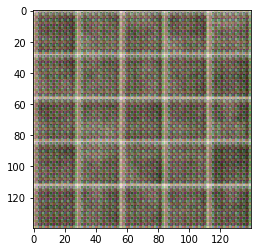

Epoch 1/1... Discriminator Loss: 1.2208... Generator Loss: 3.3354
Epoch 1/1... Discriminator Loss: 1.1379... Generator Loss: 2.4451
Epoch 1/1... Discriminator Loss: 1.1407... Generator Loss: 1.4246
Epoch 1/1... Discriminator Loss: 1.1969... Generator Loss: 1.6739
Epoch 1/1... Discriminator Loss: 1.5350... Generator Loss: 0.7353


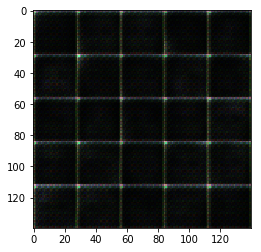

Epoch 1/1... Discriminator Loss: 1.5339... Generator Loss: 3.1790
Epoch 1/1... Discriminator Loss: 1.0773... Generator Loss: 1.3561
Epoch 1/1... Discriminator Loss: 1.5909... Generator Loss: 0.4540
Epoch 1/1... Discriminator Loss: 1.7428... Generator Loss: 0.4210
Epoch 1/1... Discriminator Loss: 1.1977... Generator Loss: 1.0080


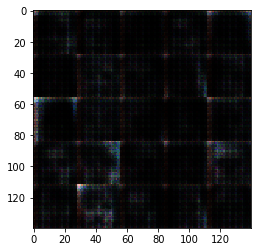

Epoch 1/1... Discriminator Loss: 1.4436... Generator Loss: 0.6413
Epoch 1/1... Discriminator Loss: 1.0787... Generator Loss: 2.3420
Epoch 1/1... Discriminator Loss: 1.2707... Generator Loss: 0.8230
Epoch 1/1... Discriminator Loss: 1.4531... Generator Loss: 0.7597
Epoch 1/1... Discriminator Loss: 1.2058... Generator Loss: 0.9013


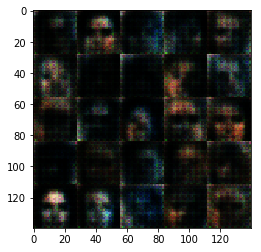

Epoch 1/1... Discriminator Loss: 1.4449... Generator Loss: 0.6249
Epoch 1/1... Discriminator Loss: 1.8994... Generator Loss: 0.3327
Epoch 1/1... Discriminator Loss: 1.0909... Generator Loss: 0.8715
Epoch 1/1... Discriminator Loss: 1.1909... Generator Loss: 0.9218
Epoch 1/1... Discriminator Loss: 0.9950... Generator Loss: 1.3711


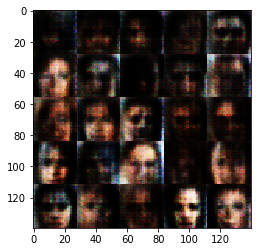

Epoch 1/1... Discriminator Loss: 1.3982... Generator Loss: 2.3108
Epoch 1/1... Discriminator Loss: 1.3147... Generator Loss: 0.7050
Epoch 1/1... Discriminator Loss: 1.4327... Generator Loss: 1.6224
Epoch 1/1... Discriminator Loss: 1.4457... Generator Loss: 0.5679
Epoch 1/1... Discriminator Loss: 1.2329... Generator Loss: 0.8357


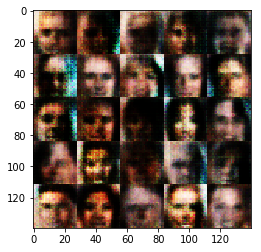

Epoch 1/1... Discriminator Loss: 1.2986... Generator Loss: 0.9778
Epoch 1/1... Discriminator Loss: 1.2827... Generator Loss: 1.0129
Epoch 1/1... Discriminator Loss: 1.3309... Generator Loss: 0.8267
Epoch 1/1... Discriminator Loss: 1.7691... Generator Loss: 0.4252
Epoch 1/1... Discriminator Loss: 1.7282... Generator Loss: 0.4089


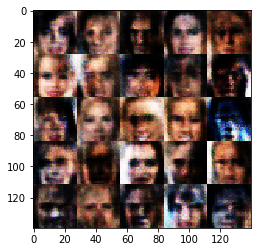

Epoch 1/1... Discriminator Loss: 1.2734... Generator Loss: 0.8248
Epoch 1/1... Discriminator Loss: 1.4577... Generator Loss: 0.7103
Epoch 1/1... Discriminator Loss: 1.6017... Generator Loss: 0.4985
Epoch 1/1... Discriminator Loss: 1.5246... Generator Loss: 0.4899
Epoch 1/1... Discriminator Loss: 1.4528... Generator Loss: 0.4875


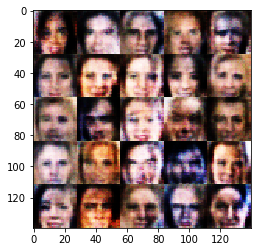

Epoch 1/1... Discriminator Loss: 1.3071... Generator Loss: 0.8833
Epoch 1/1... Discriminator Loss: 1.5438... Generator Loss: 1.6781
Epoch 1/1... Discriminator Loss: 1.5499... Generator Loss: 0.5220
Epoch 1/1... Discriminator Loss: 1.2522... Generator Loss: 0.7862
Epoch 1/1... Discriminator Loss: 2.1436... Generator Loss: 2.5670


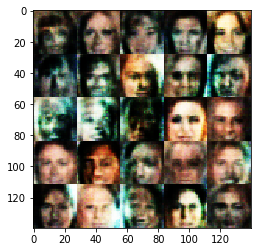

Epoch 1/1... Discriminator Loss: 1.2343... Generator Loss: 0.9707
Epoch 1/1... Discriminator Loss: 1.1889... Generator Loss: 0.9588
Epoch 1/1... Discriminator Loss: 1.3584... Generator Loss: 0.7303
Epoch 1/1... Discriminator Loss: 1.2127... Generator Loss: 0.9541
Epoch 1/1... Discriminator Loss: 1.2647... Generator Loss: 1.1807


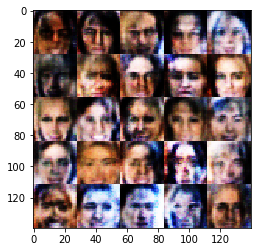

Epoch 1/1... Discriminator Loss: 1.2304... Generator Loss: 1.2761
Epoch 1/1... Discriminator Loss: 1.3563... Generator Loss: 0.6706
Epoch 1/1... Discriminator Loss: 1.0717... Generator Loss: 1.0898
Epoch 1/1... Discriminator Loss: 1.5413... Generator Loss: 0.4997
Epoch 1/1... Discriminator Loss: 1.4230... Generator Loss: 1.9659


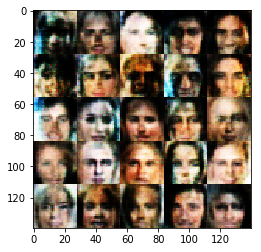

Epoch 1/1... Discriminator Loss: 1.3650... Generator Loss: 0.7010
Epoch 1/1... Discriminator Loss: 1.1157... Generator Loss: 1.0639
Epoch 1/1... Discriminator Loss: 1.3158... Generator Loss: 1.6021
Epoch 1/1... Discriminator Loss: 1.5819... Generator Loss: 0.4255
Epoch 1/1... Discriminator Loss: 1.2660... Generator Loss: 0.7924


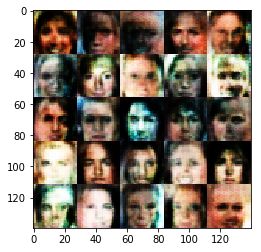

Epoch 1/1... Discriminator Loss: 1.5876... Generator Loss: 0.4114
Epoch 1/1... Discriminator Loss: 1.1621... Generator Loss: 1.1486
Epoch 1/1... Discriminator Loss: 1.2325... Generator Loss: 1.1925
Epoch 1/1... Discriminator Loss: 1.2461... Generator Loss: 0.9564
Epoch 1/1... Discriminator Loss: 1.4768... Generator Loss: 0.4928


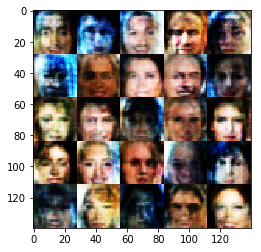

Epoch 1/1... Discriminator Loss: 1.1248... Generator Loss: 1.3928
Epoch 1/1... Discriminator Loss: 1.3019... Generator Loss: 1.6446
Epoch 1/1... Discriminator Loss: 1.2554... Generator Loss: 0.9876
Epoch 1/1... Discriminator Loss: 1.1280... Generator Loss: 1.4536
Epoch 1/1... Discriminator Loss: 1.1766... Generator Loss: 1.0858


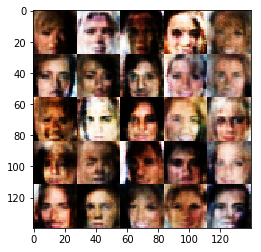

Epoch 1/1... Discriminator Loss: 1.1313... Generator Loss: 1.0253
Epoch 1/1... Discriminator Loss: 1.1912... Generator Loss: 0.8169
Epoch 1/1... Discriminator Loss: 1.0901... Generator Loss: 1.2467
Epoch 1/1... Discriminator Loss: 1.1975... Generator Loss: 1.3198
Epoch 1/1... Discriminator Loss: 1.2297... Generator Loss: 0.9550


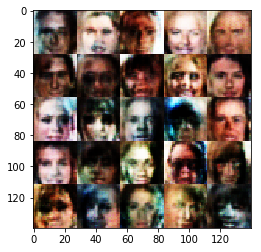

Epoch 1/1... Discriminator Loss: 1.2314... Generator Loss: 1.1091
Epoch 1/1... Discriminator Loss: 1.4456... Generator Loss: 0.5481
Epoch 1/1... Discriminator Loss: 1.1097... Generator Loss: 0.9332
Epoch 1/1... Discriminator Loss: 1.5364... Generator Loss: 2.2768
Epoch 1/1... Discriminator Loss: 1.1979... Generator Loss: 0.9236


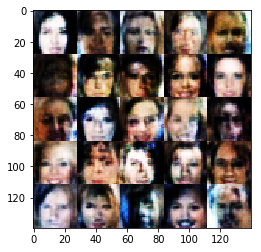

Epoch 1/1... Discriminator Loss: 1.3957... Generator Loss: 0.5686
Epoch 1/1... Discriminator Loss: 1.7978... Generator Loss: 0.4059
Epoch 1/1... Discriminator Loss: 1.5440... Generator Loss: 0.4844
Epoch 1/1... Discriminator Loss: 1.1542... Generator Loss: 1.5781
Epoch 1/1... Discriminator Loss: 1.2175... Generator Loss: 0.6930


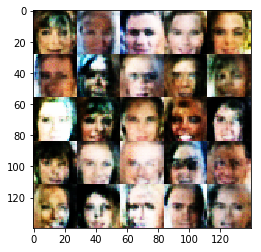

Epoch 1/1... Discriminator Loss: 1.3712... Generator Loss: 1.0247
Epoch 1/1... Discriminator Loss: 1.8732... Generator Loss: 2.0719
Epoch 1/1... Discriminator Loss: 1.1993... Generator Loss: 0.6807
Epoch 1/1... Discriminator Loss: 1.2328... Generator Loss: 1.2161
Epoch 1/1... Discriminator Loss: 1.4253... Generator Loss: 0.6149


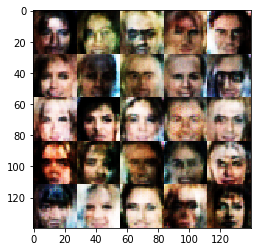

Epoch 1/1... Discriminator Loss: 1.7943... Generator Loss: 0.4421
Epoch 1/1... Discriminator Loss: 1.4190... Generator Loss: 1.4951
Epoch 1/1... Discriminator Loss: 1.1551... Generator Loss: 1.1964
Epoch 1/1... Discriminator Loss: 1.1765... Generator Loss: 1.5668
Epoch 1/1... Discriminator Loss: 1.6668... Generator Loss: 0.5190


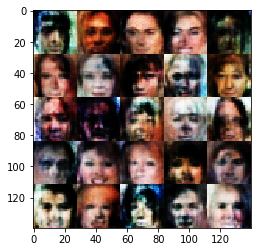

Epoch 1/1... Discriminator Loss: 1.5339... Generator Loss: 0.4896
Epoch 1/1... Discriminator Loss: 1.2415... Generator Loss: 0.6654
Epoch 1/1... Discriminator Loss: 1.1792... Generator Loss: 1.0776
Epoch 1/1... Discriminator Loss: 1.0816... Generator Loss: 1.0904
Epoch 1/1... Discriminator Loss: 1.2320... Generator Loss: 0.7351


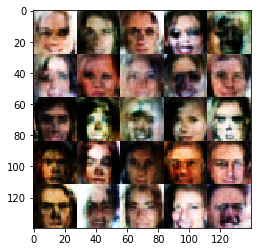

Epoch 1/1... Discriminator Loss: 0.8985... Generator Loss: 1.3623
Epoch 1/1... Discriminator Loss: 1.3468... Generator Loss: 0.8101
Epoch 1/1... Discriminator Loss: 1.1943... Generator Loss: 0.7816
Epoch 1/1... Discriminator Loss: 1.7380... Generator Loss: 0.3933
Epoch 1/1... Discriminator Loss: 1.1474... Generator Loss: 1.1592


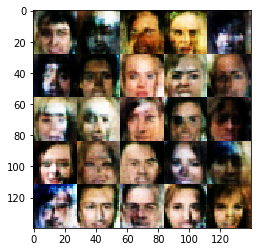

Epoch 1/1... Discriminator Loss: 1.4941... Generator Loss: 0.5204
Epoch 1/1... Discriminator Loss: 1.2363... Generator Loss: 1.6744
Epoch 1/1... Discriminator Loss: 1.2497... Generator Loss: 0.7267
Epoch 1/1... Discriminator Loss: 1.8924... Generator Loss: 0.3371
Epoch 1/1... Discriminator Loss: 1.0294... Generator Loss: 1.2126


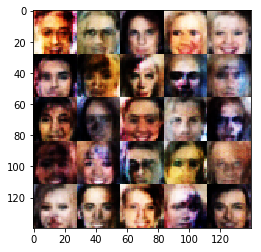

Epoch 1/1... Discriminator Loss: 1.1621... Generator Loss: 0.8508
Epoch 1/1... Discriminator Loss: 1.4754... Generator Loss: 0.4849
Epoch 1/1... Discriminator Loss: 1.1948... Generator Loss: 0.7843
Epoch 1/1... Discriminator Loss: 0.9772... Generator Loss: 1.1410
Epoch 1/1... Discriminator Loss: 1.2140... Generator Loss: 0.7833


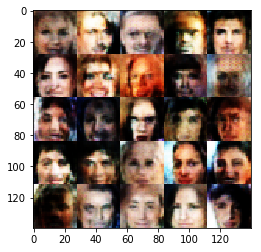

Epoch 1/1... Discriminator Loss: 1.1845... Generator Loss: 1.2308
Epoch 1/1... Discriminator Loss: 1.1628... Generator Loss: 0.7435
Epoch 1/1... Discriminator Loss: 1.1311... Generator Loss: 0.8419
Epoch 1/1... Discriminator Loss: 1.0838... Generator Loss: 1.5094
Epoch 1/1... Discriminator Loss: 1.6031... Generator Loss: 1.5036


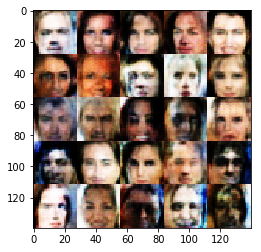

Epoch 1/1... Discriminator Loss: 1.0406... Generator Loss: 1.0645
Epoch 1/1... Discriminator Loss: 1.1612... Generator Loss: 1.0089
Epoch 1/1... Discriminator Loss: 1.2415... Generator Loss: 0.9144
Epoch 1/1... Discriminator Loss: 1.3080... Generator Loss: 0.7283
Epoch 1/1... Discriminator Loss: 1.7137... Generator Loss: 3.2185


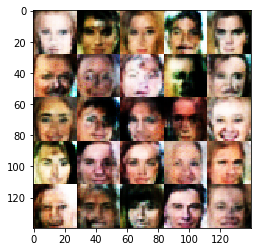

Epoch 1/1... Discriminator Loss: 1.5689... Generator Loss: 0.5070
Epoch 1/1... Discriminator Loss: 1.1071... Generator Loss: 1.4494
Epoch 1/1... Discriminator Loss: 1.8856... Generator Loss: 0.3397
Epoch 1/1... Discriminator Loss: 0.9661... Generator Loss: 1.0589
Epoch 1/1... Discriminator Loss: 1.3143... Generator Loss: 1.3033


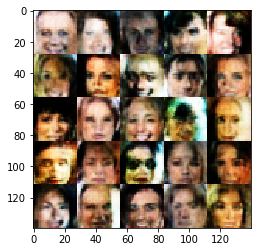

Epoch 1/1... Discriminator Loss: 1.3632... Generator Loss: 0.6094
Epoch 1/1... Discriminator Loss: 1.4895... Generator Loss: 0.5735
Epoch 1/1... Discriminator Loss: 1.0880... Generator Loss: 0.8867
Epoch 1/1... Discriminator Loss: 0.9237... Generator Loss: 1.4179
Epoch 1/1... Discriminator Loss: 1.1348... Generator Loss: 0.6930


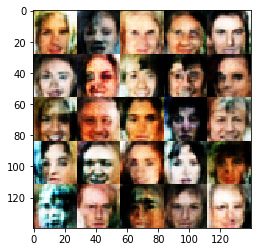

Epoch 1/1... Discriminator Loss: 1.2310... Generator Loss: 0.7616
Epoch 1/1... Discriminator Loss: 1.2205... Generator Loss: 0.6930
Epoch 1/1... Discriminator Loss: 0.8778... Generator Loss: 1.4058
Epoch 1/1... Discriminator Loss: 1.0331... Generator Loss: 1.0437
Epoch 1/1... Discriminator Loss: 1.0715... Generator Loss: 2.2971


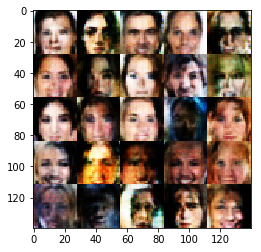

Epoch 1/1... Discriminator Loss: 1.3775... Generator Loss: 0.5786
Epoch 1/1... Discriminator Loss: 1.2200... Generator Loss: 0.7651
Epoch 1/1... Discriminator Loss: 1.5472... Generator Loss: 0.4932
Epoch 1/1... Discriminator Loss: 1.1290... Generator Loss: 0.8204
Epoch 1/1... Discriminator Loss: 1.0730... Generator Loss: 0.9302


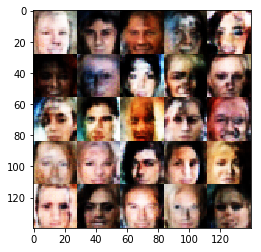

Epoch 1/1... Discriminator Loss: 1.6123... Generator Loss: 2.3660
Epoch 1/1... Discriminator Loss: 1.5330... Generator Loss: 0.4405
Epoch 1/1... Discriminator Loss: 2.2198... Generator Loss: 0.2759
Epoch 1/1... Discriminator Loss: 0.8335... Generator Loss: 1.7353
Epoch 1/1... Discriminator Loss: 1.6881... Generator Loss: 0.3766


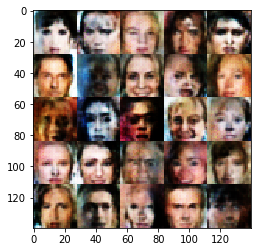

Epoch 1/1... Discriminator Loss: 1.2581... Generator Loss: 0.7827
Epoch 1/1... Discriminator Loss: 1.1360... Generator Loss: 0.8133
Epoch 1/1... Discriminator Loss: 1.5755... Generator Loss: 0.5316
Epoch 1/1... Discriminator Loss: 0.9832... Generator Loss: 1.2083
Epoch 1/1... Discriminator Loss: 0.9610... Generator Loss: 1.3995


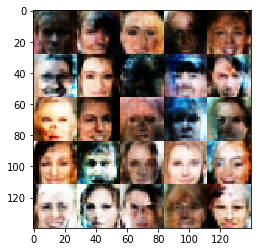

Epoch 1/1... Discriminator Loss: 0.7706... Generator Loss: 2.4632
Epoch 1/1... Discriminator Loss: 0.9135... Generator Loss: 1.3863
Epoch 1/1... Discriminator Loss: 1.2625... Generator Loss: 0.6692
Epoch 1/1... Discriminator Loss: 1.4009... Generator Loss: 0.5817
Epoch 1/1... Discriminator Loss: 1.2659... Generator Loss: 0.6639


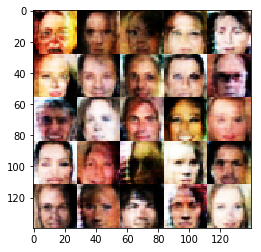

Epoch 1/1... Discriminator Loss: 1.7014... Generator Loss: 0.4325
Epoch 1/1... Discriminator Loss: 1.0928... Generator Loss: 1.0688
Epoch 1/1... Discriminator Loss: 1.3776... Generator Loss: 1.9869
Epoch 1/1... Discriminator Loss: 1.6080... Generator Loss: 1.9896
Epoch 1/1... Discriminator Loss: 1.1925... Generator Loss: 0.8348


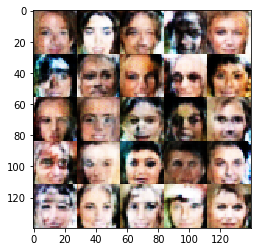

Epoch 1/1... Discriminator Loss: 0.9912... Generator Loss: 1.3321
Epoch 1/1... Discriminator Loss: 1.1985... Generator Loss: 0.9623
Epoch 1/1... Discriminator Loss: 1.0728... Generator Loss: 1.4766
Epoch 1/1... Discriminator Loss: 1.2187... Generator Loss: 0.7670
Epoch 1/1... Discriminator Loss: 1.7248... Generator Loss: 0.3351


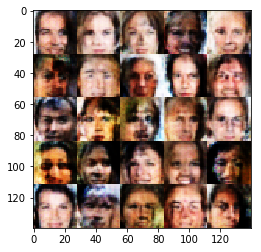

Epoch 1/1... Discriminator Loss: 1.0526... Generator Loss: 1.2091
Epoch 1/1... Discriminator Loss: 0.9363... Generator Loss: 1.1530
Epoch 1/1... Discriminator Loss: 0.8036... Generator Loss: 1.6148
Epoch 1/1... Discriminator Loss: 1.5326... Generator Loss: 1.4817
Epoch 1/1... Discriminator Loss: 1.3456... Generator Loss: 0.7939


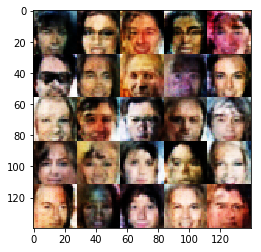

Epoch 1/1... Discriminator Loss: 1.1473... Generator Loss: 0.8990
Epoch 1/1... Discriminator Loss: 0.9365... Generator Loss: 1.6440
Epoch 1/1... Discriminator Loss: 1.0412... Generator Loss: 1.5856
Epoch 1/1... Discriminator Loss: 1.3781... Generator Loss: 1.7878
Epoch 1/1... Discriminator Loss: 1.3342... Generator Loss: 0.5978


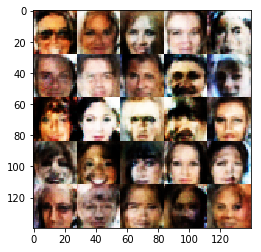

Epoch 1/1... Discriminator Loss: 2.0886... Generator Loss: 0.2611
Epoch 1/1... Discriminator Loss: 1.5839... Generator Loss: 0.4981
Epoch 1/1... Discriminator Loss: 1.0689... Generator Loss: 1.0392
Epoch 1/1... Discriminator Loss: 0.9161... Generator Loss: 1.7751
Epoch 1/1... Discriminator Loss: 1.1820... Generator Loss: 1.8122


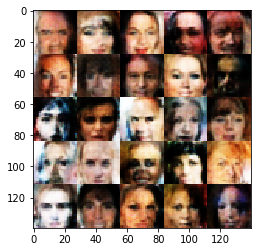

Epoch 1/1... Discriminator Loss: 1.6135... Generator Loss: 0.4651
Epoch 1/1... Discriminator Loss: 1.1942... Generator Loss: 1.1782
Epoch 1/1... Discriminator Loss: 1.8358... Generator Loss: 0.3315
Epoch 1/1... Discriminator Loss: 1.0433... Generator Loss: 1.5989
Epoch 1/1... Discriminator Loss: 1.4707... Generator Loss: 2.2009


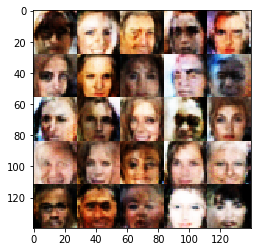

Epoch 1/1... Discriminator Loss: 1.0023... Generator Loss: 1.0175
Epoch 1/1... Discriminator Loss: 1.7362... Generator Loss: 0.4484
Epoch 1/1... Discriminator Loss: 1.3703... Generator Loss: 0.5991
Epoch 1/1... Discriminator Loss: 1.2833... Generator Loss: 0.7834
Epoch 1/1... Discriminator Loss: 1.3776... Generator Loss: 0.6277


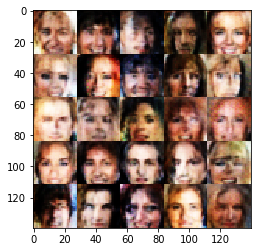

Epoch 1/1... Discriminator Loss: 1.0713... Generator Loss: 2.5352
Epoch 1/1... Discriminator Loss: 1.8747... Generator Loss: 0.4305
Epoch 1/1... Discriminator Loss: 1.1657... Generator Loss: 0.7508
Epoch 1/1... Discriminator Loss: 1.4615... Generator Loss: 0.5507
Epoch 1/1... Discriminator Loss: 1.0730... Generator Loss: 1.6500


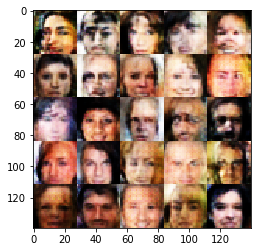

Epoch 1/1... Discriminator Loss: 1.1103... Generator Loss: 0.8387
Epoch 1/1... Discriminator Loss: 1.3866... Generator Loss: 2.2828
Epoch 1/1... Discriminator Loss: 2.2730... Generator Loss: 0.2893
Epoch 1/1... Discriminator Loss: 1.8266... Generator Loss: 0.3657
Epoch 1/1... Discriminator Loss: 0.9369... Generator Loss: 1.5697


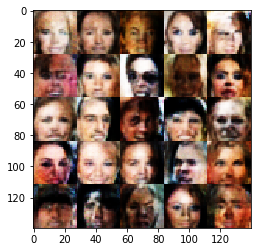

Epoch 1/1... Discriminator Loss: 0.9112... Generator Loss: 1.2697
Epoch 1/1... Discriminator Loss: 1.3410... Generator Loss: 2.0726
Epoch 1/1... Discriminator Loss: 0.9441... Generator Loss: 0.9872
Epoch 1/1... Discriminator Loss: 1.7422... Generator Loss: 0.4124
Epoch 1/1... Discriminator Loss: 1.0675... Generator Loss: 1.5148


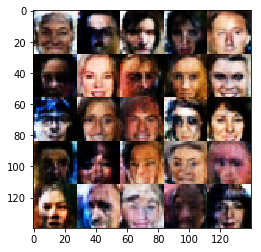

Epoch 1/1... Discriminator Loss: 1.3436... Generator Loss: 0.5982
Epoch 1/1... Discriminator Loss: 1.0421... Generator Loss: 1.1155
Epoch 1/1... Discriminator Loss: 1.3797... Generator Loss: 0.5697
Epoch 1/1... Discriminator Loss: 1.0133... Generator Loss: 1.5267
Epoch 1/1... Discriminator Loss: 1.0920... Generator Loss: 0.8504


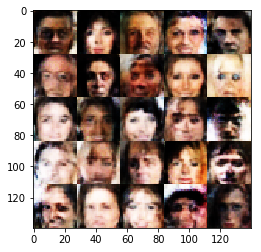

Epoch 1/1... Discriminator Loss: 1.1113... Generator Loss: 1.3931
Epoch 1/1... Discriminator Loss: 1.3229... Generator Loss: 1.3276
Epoch 1/1... Discriminator Loss: 1.4527... Generator Loss: 0.5360
Epoch 1/1... Discriminator Loss: 1.5173... Generator Loss: 0.5125
Epoch 1/1... Discriminator Loss: 1.0746... Generator Loss: 0.9900


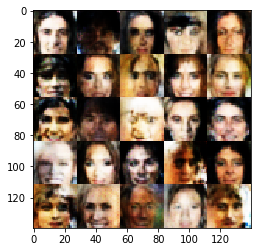

Epoch 1/1... Discriminator Loss: 1.7709... Generator Loss: 0.3263
Epoch 1/1... Discriminator Loss: 1.0933... Generator Loss: 0.9585
Epoch 1/1... Discriminator Loss: 1.4075... Generator Loss: 0.5354
Epoch 1/1... Discriminator Loss: 1.1443... Generator Loss: 2.0345
Epoch 1/1... Discriminator Loss: 1.1403... Generator Loss: 1.8171


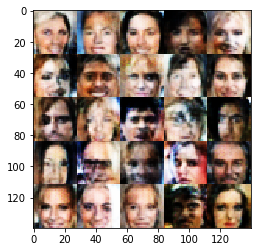

Epoch 1/1... Discriminator Loss: 1.5746... Generator Loss: 0.4716
Epoch 1/1... Discriminator Loss: 1.1360... Generator Loss: 0.9157
Epoch 1/1... Discriminator Loss: 1.2504... Generator Loss: 0.8710
Epoch 1/1... Discriminator Loss: 1.0769... Generator Loss: 0.9637
Epoch 1/1... Discriminator Loss: 1.1233... Generator Loss: 1.0025


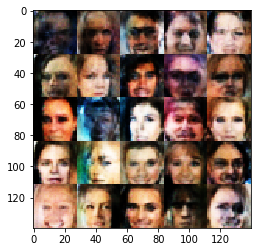

Epoch 1/1... Discriminator Loss: 1.2746... Generator Loss: 0.6873
Epoch 1/1... Discriminator Loss: 1.1189... Generator Loss: 0.9164
Epoch 1/1... Discriminator Loss: 1.0227... Generator Loss: 1.4557
Epoch 1/1... Discriminator Loss: 1.2232... Generator Loss: 0.7511
Epoch 1/1... Discriminator Loss: 1.1234... Generator Loss: 1.1579


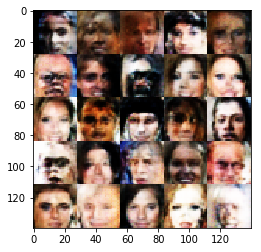

Epoch 1/1... Discriminator Loss: 0.9153... Generator Loss: 1.4120
Epoch 1/1... Discriminator Loss: 1.0389... Generator Loss: 1.2266
Epoch 1/1... Discriminator Loss: 0.9554... Generator Loss: 1.1228
Epoch 1/1... Discriminator Loss: 1.3329... Generator Loss: 1.6860
Epoch 1/1... Discriminator Loss: 1.6084... Generator Loss: 0.4875


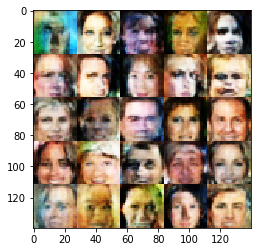

Epoch 1/1... Discriminator Loss: 1.0075... Generator Loss: 1.0515
Epoch 1/1... Discriminator Loss: 1.0056... Generator Loss: 1.0785
Epoch 1/1... Discriminator Loss: 0.9716... Generator Loss: 1.1188
Epoch 1/1... Discriminator Loss: 1.0270... Generator Loss: 0.9832
Epoch 1/1... Discriminator Loss: 1.6185... Generator Loss: 0.5308


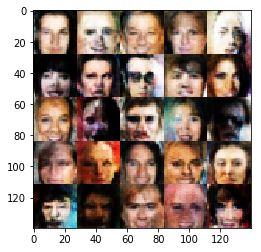

Epoch 1/1... Discriminator Loss: 1.6063... Generator Loss: 0.4451
Epoch 1/1... Discriminator Loss: 0.9791... Generator Loss: 1.1136
Epoch 1/1... Discriminator Loss: 1.8198... Generator Loss: 0.3656
Epoch 1/1... Discriminator Loss: 1.1593... Generator Loss: 0.8602
Epoch 1/1... Discriminator Loss: 1.4557... Generator Loss: 0.5506


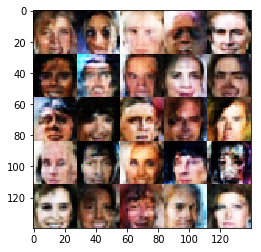

Epoch 1/1... Discriminator Loss: 1.0607... Generator Loss: 1.0913
Epoch 1/1... Discriminator Loss: 1.2934... Generator Loss: 1.6158
Epoch 1/1... Discriminator Loss: 1.4973... Generator Loss: 0.4813
Epoch 1/1... Discriminator Loss: 0.8675... Generator Loss: 1.6356
Epoch 1/1... Discriminator Loss: 1.2678... Generator Loss: 0.6727


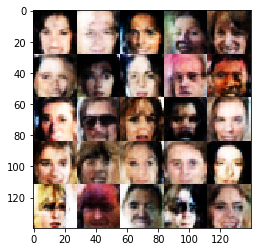

Epoch 1/1... Discriminator Loss: 1.3344... Generator Loss: 1.3617
Epoch 1/1... Discriminator Loss: 1.6956... Generator Loss: 0.4018
Epoch 1/1... Discriminator Loss: 1.1769... Generator Loss: 0.7466
Epoch 1/1... Discriminator Loss: 0.8962... Generator Loss: 1.4583
Epoch 1/1... Discriminator Loss: 1.5110... Generator Loss: 0.5199


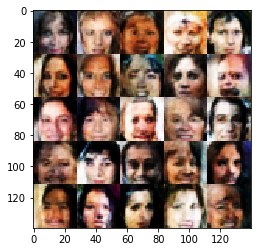

Epoch 1/1... Discriminator Loss: 1.6859... Generator Loss: 0.4928
Epoch 1/1... Discriminator Loss: 1.4315... Generator Loss: 0.6148
Epoch 1/1... Discriminator Loss: 1.0502... Generator Loss: 0.9245
Epoch 1/1... Discriminator Loss: 1.7187... Generator Loss: 0.3998
Epoch 1/1... Discriminator Loss: 1.2063... Generator Loss: 0.6914


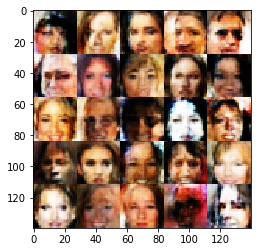

Epoch 1/1... Discriminator Loss: 1.3506... Generator Loss: 1.9503
Epoch 1/1... Discriminator Loss: 1.3461... Generator Loss: 0.6491
Epoch 1/1... Discriminator Loss: 1.8206... Generator Loss: 0.3935
Epoch 1/1... Discriminator Loss: 1.4886... Generator Loss: 0.4629
Epoch 1/1... Discriminator Loss: 1.0527... Generator Loss: 0.8905


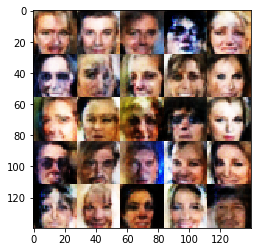

Epoch 1/1... Discriminator Loss: 1.2223... Generator Loss: 1.0906
Epoch 1/1... Discriminator Loss: 1.3683... Generator Loss: 0.6742
Epoch 1/1... Discriminator Loss: 1.9464... Generator Loss: 0.3423
Epoch 1/1... Discriminator Loss: 1.0645... Generator Loss: 1.0058
Epoch 1/1... Discriminator Loss: 1.4638... Generator Loss: 0.5864


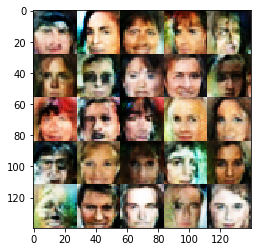

Epoch 1/1... Discriminator Loss: 1.2022... Generator Loss: 1.3588
Epoch 1/1... Discriminator Loss: 1.3178... Generator Loss: 1.0559
Epoch 1/1... Discriminator Loss: 1.3855... Generator Loss: 0.5540
Epoch 1/1... Discriminator Loss: 1.2956... Generator Loss: 2.0599
Epoch 1/1... Discriminator Loss: 1.0681... Generator Loss: 0.9132


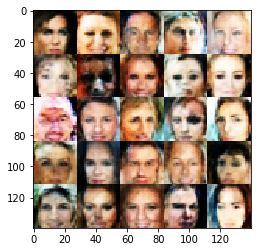

Epoch 1/1... Discriminator Loss: 1.5350... Generator Loss: 0.5504
Epoch 1/1... Discriminator Loss: 1.0420... Generator Loss: 1.1895
Epoch 1/1... Discriminator Loss: 1.1917... Generator Loss: 0.7542
Epoch 1/1... Discriminator Loss: 1.0810... Generator Loss: 0.9356
Epoch 1/1... Discriminator Loss: 0.8684... Generator Loss: 2.1607


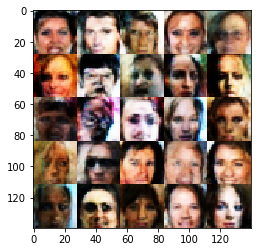

Epoch 1/1... Discriminator Loss: 1.4214... Generator Loss: 1.8174
Epoch 1/1... Discriminator Loss: 1.5779... Generator Loss: 0.5531
Epoch 1/1... Discriminator Loss: 1.6450... Generator Loss: 0.4290
Epoch 1/1... Discriminator Loss: 1.1566... Generator Loss: 0.8577
Epoch 1/1... Discriminator Loss: 1.2340... Generator Loss: 1.6953


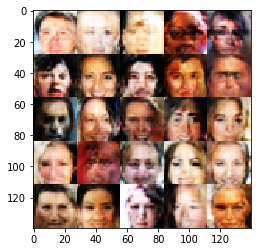

Epoch 1/1... Discriminator Loss: 1.2352... Generator Loss: 0.7667
Epoch 1/1... Discriminator Loss: 1.6510... Generator Loss: 1.4184
Epoch 1/1... Discriminator Loss: 1.0268... Generator Loss: 1.0849
Epoch 1/1... Discriminator Loss: 1.4090... Generator Loss: 0.5070
Epoch 1/1... Discriminator Loss: 1.0465... Generator Loss: 0.9168


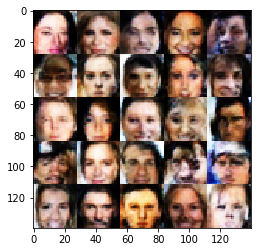

Epoch 1/1... Discriminator Loss: 0.8833... Generator Loss: 1.4654
Epoch 1/1... Discriminator Loss: 1.1262... Generator Loss: 1.4564
Epoch 1/1... Discriminator Loss: 1.3809... Generator Loss: 0.5896
Epoch 1/1... Discriminator Loss: 1.0142... Generator Loss: 1.4487
Epoch 1/1... Discriminator Loss: 1.7758... Generator Loss: 0.4076


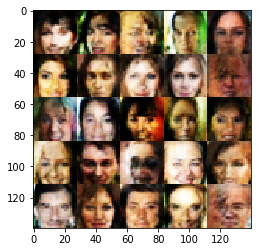

Epoch 1/1... Discriminator Loss: 1.4537... Generator Loss: 1.7786
Epoch 1/1... Discriminator Loss: 1.2158... Generator Loss: 0.7420
Epoch 1/1... Discriminator Loss: 1.2995... Generator Loss: 1.5281
Epoch 1/1... Discriminator Loss: 1.2887... Generator Loss: 1.0583
Epoch 1/1... Discriminator Loss: 0.9738... Generator Loss: 1.0155


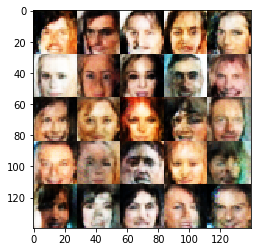

Epoch 1/1... Discriminator Loss: 1.4055... Generator Loss: 1.6213
Epoch 1/1... Discriminator Loss: 1.3565... Generator Loss: 0.5806
Epoch 1/1... Discriminator Loss: 1.1079... Generator Loss: 1.6555
Epoch 1/1... Discriminator Loss: 1.2740... Generator Loss: 0.8037
Epoch 1/1... Discriminator Loss: 1.0069... Generator Loss: 1.4078


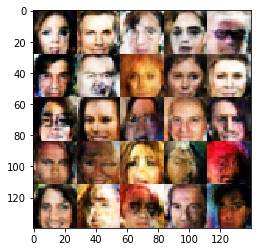

Epoch 1/1... Discriminator Loss: 1.5822... Generator Loss: 0.5600
Epoch 1/1... Discriminator Loss: 1.0729... Generator Loss: 0.9496
Epoch 1/1... Discriminator Loss: 1.2189... Generator Loss: 2.0371
Epoch 1/1... Discriminator Loss: 1.2715... Generator Loss: 0.7157
Epoch 1/1... Discriminator Loss: 1.7153... Generator Loss: 0.4287


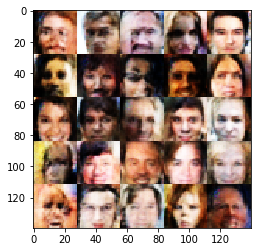

Epoch 1/1... Discriminator Loss: 1.4109... Generator Loss: 0.6294


In [14]:
batch_size = 64
z_dim = 100
learning_rate = 0.0002
alpha = 0.05
beta1 = 0.3

"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 1

celeba_dataset = helper.Dataset('celeba', glob(os.path.join(data_dir, 'img_align_celeba/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, celeba_dataset.get_batches,
          celeba_dataset.shape, celeba_dataset.image_mode, alpha=alpha)

### Submitting This Project
When submitting this project, make sure to run all the cells before saving the notebook. Save the notebook file as "dlnd_face_generation.ipynb" and save it as a HTML file under "File" -> "Download as". Include the "helper.py" and "problem_unittests.py" files in your submission.